In [1]:
import datetime
import os
import cv2
import numpy as np
import pandas as pd
from facenet_pytorch import MTCNN
from matplotlib import pyplot as plt
from keras.models import load_model
from pytube import YouTube

import random
import seaborn as sns
import plotly.express as px

/Users/steve/Neue_Fische/NeuralXpresso/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [54]:
# Load the video from YouTube
yt_link = "https://www.youtube.com/watch?v=vtT78TfDfXU&ab_channel=OsamaRomoh"
yt = YouTube(yt_link)
stream = yt.streams.first()
stream.download()
video = cv2.VideoCapture(stream.default_filename)

# Initialize the face detection model
face_detector = MTCNN(keep_all=True, post_process=False, margin=20)

# Initialize the emotion detection model
emotion_classifier = load_model("../models/emotion_model.hdf5", compile=False)
input_face_size = emotion_classifier.input_shape[1:3]

# Initialize lists to store faces and emotions
list_of_faces = []
list_of_emotions = []

# Set the frame rate and the number of frames to skip between each face detection
frame_rate = 30
skip_frames = int(video.get(cv2.CAP_PROP_FPS) / frame_rate)
frames_without_faces_counter = 0

# Loop through each frame of the video
while True:

    # Read the next frame from the video
    ret, frame = video.read()

    # Check if the frame was successfully read
    if not ret:
        break

    # Convert the frame from BGR to RGB color space
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Detect faces in the frame using the MTCNN model
    faces = face_detector(frame)

    # Check if any faces were found
    if faces is None:
        frames_without_faces_counter += 1
        continue

    # Extract the faces from the tensor and add them to the list
    for face in faces:
        # Convert the face from a PyTorch tensor to a NumPy array
        face = face.permute(1, 2, 0).numpy()
        # Gray scale
        face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
        # Resize the face to the input size of the emotion detection model
        face = cv2.resize(face, input_face_size)
        # Normalize the pixel values
        face = face.astype('float32') / 255.0
        # Add a batch dimension to the face
        face = np.expand_dims(face, axis=0)
        # Predict the emotions for the face using the emotion detection model
        prob = emotion_classifier.predict(face)[0]
        # Apply the softmax activation function to the probabilities
        #prob = np.exp(prob) / np.sum(np.exp(prob))
        # Add the probabilities to the list of emotions
        list_of_emotions.append(prob)
        # Add the face to the list of faces
        list_of_faces.append(face)

# Release the video and close the window
video.release()

# Print some statistics about the faces and emotions detected
print(f'{len(list_of_faces)} faces found in {len(list_of_emotions)} frames with at least one face.')
print(f'{frames_without_faces_counter} frames had no face detected ({round(100*frames_without_faces_counter/len(list_of_emotions),2)}%).')

# Convert the list of emotions to a NumPy array
emotions = np.vstack(list_of_emotions)

# Save the emotions array to a CSV file
np.savetxt('emotions.csv', emotions, delimiter=',')

# Plot the distribution of the emotions over time
emotions_df = pd.DataFrame(emotions, columns=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'])
emotions_df['Frame'] = np.arange(len(emotions_df))

2023-03-16 13:13:21.197993: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


886 faces found in 886 frames with at least one face.
7 frames had no face detected (0.79%).


In [55]:
emotions_df

,Angry,Disgust,Fear,Happy,Sad,Surprise,Neutral,Frame
0,0.005274,3.739191e-06,0.008055,0.955532,0.011023,0.000607,0.019505,0
1,0.010392,2.038328e-06,0.008285,0.935133,0.015989,0.001027,0.029171,1
2,0.008759,9.634493e-07,0.008352,0.923429,0.012843,0.001177,0.045438,2
3,0.028516,5.410534e-06,0.047435,0.822713,0.031229,0.004387,0.065715,3
4,0.004002,1.981441e-06,0.008290,0.938086,0.017477,0.001190,0.030954,4
...,...,...,...,...,...,...,...,...
881,0.108445,3.996157e-05,0.076615,0.507732,0.120049,0.002081,0.185039,881
882,0.105267,1.240455e-04,0.102318,0.367060,0.169890,0.002914,0.252427,882
883,0.105267,1.240455e-04,0.102318,0.367060,0.169890,0.002914,0.252427,883
884,0.118554,1.076224e-04,0.092932,0.399157,0.145615,0.002907,0.240728,884


In [56]:
df_emotions = emotions_df

df_plotting = pd.melt(df_emotions, id_vars=['Frame'], value_vars=['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral'], var_name='feeling', value_name='probability')

In [78]:

df_emotions.head()

,Angry,Disgust,Fear,Happy,Sad,Surprise,Neutral,Frame
0,0.005274,3.739191e-06,0.008055,0.955532,0.011023,0.000607,0.019505,0
1,0.010392,2.038328e-06,0.008285,0.935133,0.015989,0.001027,0.029171,1
2,0.008759,9.634493e-07,0.008352,0.923429,0.012843,0.001177,0.045438,2
3,0.028516,5.410534e-06,0.047435,0.822713,0.031229,0.004387,0.065715,3
4,0.004002,1.981441e-06,0.008290,0.938086,0.017477,0.001190,0.030954,4


In [93]:
df_10th = df_emotions[df_emotions["Frame"] % 3 == 0]  # select every 10th frame

fig = px.bar(df_10th, x="Frame", y=["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"], 
             barmode="stack", title="Distribution of Emotions across Frames (every 10th frame)")
fig.update_layout(xaxis_title="Frame", yaxis_title="Emotion Distribution",     title={
        'y': 0.9,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    })
fig.show()

In [67]:
df_10th = df_emotions[df_emotions["Frame"] % 20 == 0]  # select every 10th frame

# assuming your DataFrame is named df
fig = px.area(df_10th, x='Frame', y=["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"],
              color_discrete_sequence=px.colors.sequential.Viridis, title="Emotion-Map")

fig.update_layout(
    autosize=False,
    width=600,
    height=500,
    margin=dict(
        l=50,
        r=50,
        b=50,
        t=50,
        pad=4
    ),
    yaxis=dict(
        title='Emotion distribution'
    ),
    xaxis=dict(
        title='Frame'
    ),
    title={
        'y': 0.97,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    }
)

fig.show()

<Axes: xlabel='Frame', ylabel='probability'>

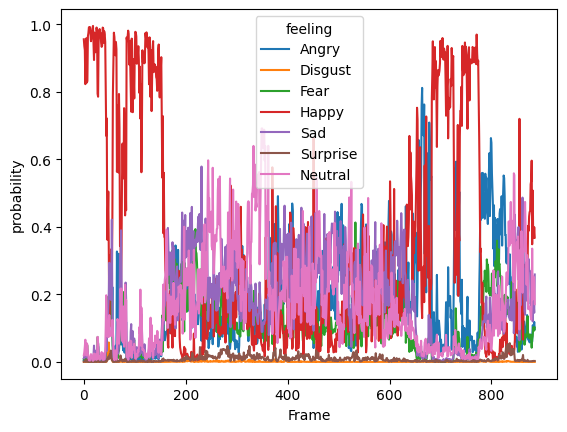

In [68]:
sns.lineplot(data = df_plotting, x = 'Frame', y='probability', hue = 'feeling')

In [69]:
fig = px.area(df_plotting, x="Frame", y="probability", color="feeling")
fig.show()

In [81]:
df = df_plotting
df['moving_avg'] = df['probability'].rolling(window=10, center=True).mean()

In [82]:
fig = px.area(df, x="Frame", y="moving_avg", color="feeling")
fig.show()

<Axes: xlabel='Frame', ylabel='moving_avg'>

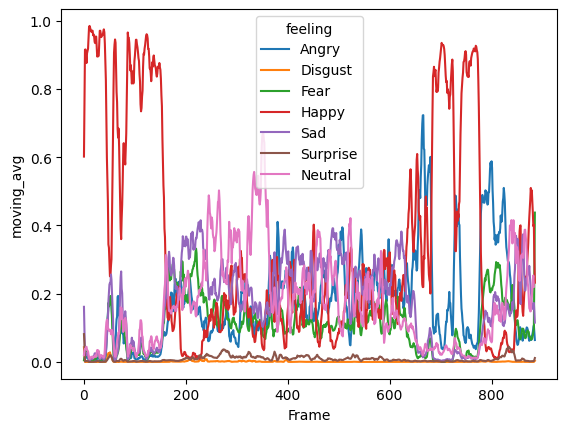

In [71]:
sns.lineplot(data = df_plotting, x = 'Frame', y='moving_avg', hue = 'feeling')

In [87]:
df_plotting

,Frame,feeling,probability,moving_avg
0,0,Angry,0.005274,NaN
1,1,Angry,0.010392,NaN
2,2,Angry,0.008759,NaN
3,3,Angry,0.028516,NaN
4,4,Angry,0.004002,NaN
...,...,...,...,...
6197,881,Neutral,0.185039,0.202502
6198,882,Neutral,0.252427,NaN
6199,883,Neutral,0.252427,NaN
6200,884,Neutral,0.240728,NaN


In [90]:
max_prob_rows = df_plotting.groupby('Frame')['probability'].idxmax().reset_index()
max_prob_df = df.loc[max_prob_rows['probability']]
feeling_counts = max_prob_df.groupby('feeling')['Frame'].nunique()
max_prob_df


,Frame,feeling,probability,moving_avg
2658,0,Happy,0.955532,0.505082
2659,1,Happy,0.935133,0.593292
2660,2,Happy,0.923429,0.665813
2661,3,Happy,0.822713,0.738803
2662,4,Happy,0.938086,0.825939
...,...,...,...,...
3539,881,Happy,0.507732,0.446257
3540,882,Happy,0.367060,0.402680
3541,883,Happy,0.367060,0.351637
3542,884,Happy,0.399157,0.299369


<Axes: xlabel='Frame', ylabel='probability'>

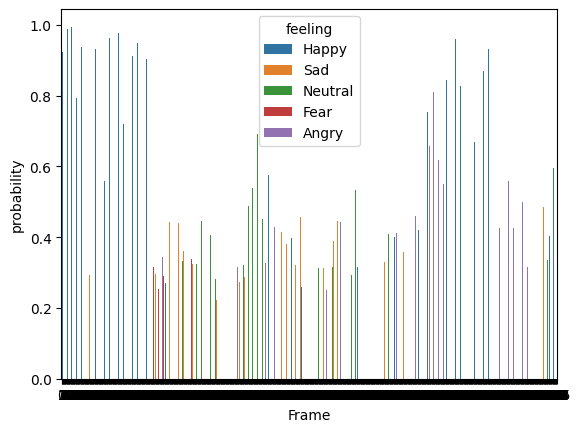

In [92]:
sns.barplot(data = max_prob_df, x = 'Frame', y='probability', hue='feeling')

In [145]:
'''
# sort dataframe by probability within each frame
sorted_df = df.sort_values(['frame', 'probability'], ascending=[True, False])

# get the top three probabilities for each frame
top_three_probs = sorted_df.groupby('frame').head(3)

# group by feeling and count unique frames
feeling_counts = top_three_probs.groupby('feeling')['frame'].nunique()

# print top three probabilities for each frame
print(top_three_probs)
'''

"\n# sort dataframe by probability within each frame\nsorted_df = df.sort_values(['frame', 'probability'], ascending=[True, False])\n\n# get the top three probabilities for each frame\ntop_three_probs = sorted_df.groupby('frame').head(3)\n\n# group by feeling and count unique frames\nfeeling_counts = top_three_probs.groupby('feeling')['frame'].nunique()\n\n# print top three probabilities for each frame\nprint(top_three_probs)\n"

In [28]:

# sort dataframe by probability within each frame
sorted_df = df.sort_values(['Frame', 'probability'], ascending=[True, False])

# get the top three probabilities for each frame
top_three_probs = sorted_df.groupby('Frame').head(3)

# count the number of occurrences of each feeling for each frame
feeling_counts = top_three_probs.groupby(['Frame', 'feeling'])['probability'].count().reset_index()

# calculate the total probability for each frame
frame_total = feeling_counts.groupby('Frame')['probability'].sum().reset_index()

# merge the feeling counts and frame totals dataframes
merged = pd.merge(feeling_counts, frame_total, on='Frame', suffixes=('_count', '_total'))

# calculate the normalized distribution of each feeling for each frame
merged['probability_normalized'] = merged['probability_count'] / merged['probability_total']

# create a stacked area chart using Plotly
fig = px.area(
    merged, 
    x='Frame', 
    y='probability_normalized', 
    color='feeling', 
    color_discrete_sequence=px.colors.qualitative.Plotly,
    title='Normalized Feeling Distribution',
    labels={
        'Frame': 'Frame',
        'probability_normalized': 'Probability',
        'feeling': 'Feeling'
    }
)

fig.show()


In [29]:
import plotly.graph_objs as go

# group the dataframe by feeling and count the number of unique frames for each feeling
feeling_counts = max_prob_df.groupby('feeling')['Frame'].nunique()

# create a bar chart with the feeling counts
data = go.Bar(x=feeling_counts.index, y=feeling_counts.values)

# create the layout for the chart
layout = go.Layout(title='Prevalence of feelings')

# create the figure object and display the chart
fig = go.Figure(data=[data], layout=layout)
fig.show()

In [30]:
# create the data for the outer and inner rings
outer_data = go.Pie(labels=feeling_counts.index, values=feeling_counts.values, hole=0.45)
inner_data = go.Pie(labels=[''], values=[1], hole=1, marker=dict(colors=['white']))

# create the layout for the chart
layout = go.Layout(title='Prevalence of feelings', annotations=[{
            'text': 'Total frames: {}'.format(len(max_prob_df)),
            'font': {'size': 20},
            'showarrow': False,
            'x': 0.5,
            'y': 0.5
        }])

# create the figure object and display the chart
fig = go.Figure(data=[outer_data, inner_data], layout=layout)
fig.show()

In [31]:
categories = ["angry",
            "disgust",
            "fear",
            "happy",
            "sad",
            "surprise",
            "neutral"]
#values = [max_prob_df[max_prob_df['feeling'] == category]['frame'].nunique() for category in categories]

# Define the categories and values
#categories = feeling_counts.index
values = feeling_counts.values

# Create the radar chart
data = go.Scatterpolar(
    r = values,
    theta = categories,
    fill = 'toself',
    name = 'Prevalence of feelings'
)

# Set the layout for the chart
layout = go.Layout(
    polar = dict(
        radialaxis = dict(
            visible = False,
            range = [0, max(values)]
        )
    ),
    showlegend = False,
    title = 'Prevalence of feelings'
)

# Create the figure object and display the chart
fig = go.Figure(data=[data], layout=layout)
fig.show()

In [150]:
from paz.pipelines import MiniXceptionFER

classify = MiniXceptionFER()

In [151]:
emotion_categories= {
            0: "angry",
            1: "disgust",
            2: "fear",
            3: "happy",
            4: "sad",
            5: "surprise",
            6: "neutral",
        }

In [152]:
# Display the first image in the results list
plt.imshow(results[66], cmap='gray')
plt.show()

NameError: name 'results' is not defined

Old / not yet used

In [ ]:

    
    # Loop through each detected face and perform emotion detection
    for (x, y, w, h) in faces:
        face_img = frame[y:y+h, x:x+w]
        emotion_preds = DeepFace.analyze(face_img, actions=["emotion"])
        emotion_dict = emotion_preds["emotion"]

        #labels for plotting on video
        emotion_label = max(emotion_preds["emotion"].items(), key=lambda x: x[1])  # get the label with the highest probability
        cv2.putText(frame, emotion_label[0], (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        
        # Add the timestamp and emotion probabilities to the dataframe
        timestamp = frame_count / video.get(cv2.CAP_PROP_FPS)
        row = {'timestamp': timestamp, 'emotion': emotion_dict}
        df = df.append(row, ignore_index=True)
        
        # Draw a rectangle around the face and display the dominant emotion
        emotion_label = max(emotion_dict.items(), key=lambda x: x[1])[0]
        cv2.putText(frame, emotion_label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
    
    # Show the frame with the detected faces and emotions
    cv2.imshow("Emotion Detection", frame)
    if cv2.waitKey(1) == ord("q"):
        break

# Release the video and close the window
video.release()
cv2.destroyAllWindows()

# Print the dataframe
print(df)

ValueError: Face could not be detected. Please confirm that the picture is a face photo or consider to set enforce_detection param to False.